## 08: Network-Based Accessibility Analysis with OSMnx

**Goal:** To perform a more rigorous accessibility analysis by calculating travel times from many origins to the nearest of several destinations over a real-world street network.

This notebook builds on concepts from notebooks 04 and 06. We will:
1.  Use `osmnx` to download the street network for Exeter.
2.  Define a set of destinations (e.g., supermarkets).
3.  Define a set of origins (we'll use the centroids of LSOA polygons as proxies for residential areas).
4.  Calculate the network travel time from each origin to its **single nearest** destination.
5.  Create a choropleth map showing accessibility scores (travel times) across the city, highlighting areas with better or worse access to essential services.

### 1. Setup and Library Imports

In [5]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np

# Configure osmnx
ox.settings.log_console = True
ox.settings.use_cache = True

### 2. Download Data: Street Network and Points of Interest

`osmnx` can not only download street networks but also Points of Interest (POIs) like supermarkets directly from OpenStreetMap.

In [3]:
place_name = "Exeter, England"

# Get the street network for driving
G = ox.graph_from_place(place_name, network_type='drive')

# Add edge speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Get supermarket POIs from OpenStreetMap
tags = {"shop": "supermarket"}
supermarkets = ox.features_from_place(place_name, tags)

print(f"Downloaded network with {len(G.nodes)} nodes and {len(G.edges)} edges.")
print(f"Found {len(supermarkets)} supermarkets.")

Downloaded network with 5343 nodes and 11390 edges.
Found 19 supermarkets.


### 3. Prepare Origins (LSOA Centroids)

We'll reuse the LSOA data from notebook 06. The centroid of each LSOA will represent an origin point for our analysis.

In [6]:
# Load LSOA data (using placeholder creation from notebook 06 if not available)
try:
    lsoa_gdf = gpd.read_file('data/LSOA_2021_Boundaries_Full_Clipped.shp')
except Exception:
    print("Could not load local LSOA data. Using a placeholder GeoDataFrame.")
    from shapely.geometry import box
    xmin, ymin, xmax, ymax = -3.58, 50.68, -3.42, 50.78
    grid_cells = []
    lsoa_codes = []
    for i, x in enumerate(np.linspace(xmin, xmax, 10)):
        for j, y in enumerate(np.linspace(ymin, ymax, 10)):
            grid_cells.append(box(x, y, x + (xmax-xmin)/10, y + (ymax-ymin)/10))
            lsoa_codes.append(f'E0101{i:02d}{j:02d}')
    lsoa_gdf = gpd.GeoDataFrame({'LSOA21CD': lsoa_codes}, geometry=grid_cells, crs="EPSG:4326")

# Ensure CRS matches the network
if lsoa_gdf.crs != G.graph['crs']:
    lsoa_gdf = lsoa_gdf.to_crs(G.graph['crs'])

# Calculate centroids
origins = lsoa_gdf.copy()
origins['geometry'] = origins.centroid

print(f"Created {len(origins)} origin points from LSOA centroids.")

Could not load local LSOA data. Using a placeholder GeoDataFrame.
Created 100 origin points from LSOA centroids.


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_26034/2115711814.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins['geometry'] = origins.centroid


### 4. Perform Accessibility Calculation

This is the core of the analysis. We find the nearest network node to every origin and every destination. Then, we calculate the shortest path travel time from each origin node to the *nearest* destination node.

In [14]:
# 1. (Re)project your graph & GeoDataFrames to a metric CRS if you haven't already:
G = ox.project_graph(G)
crs_proj = G.graph['crs']
lsoa_gdf     = lsoa_gdf.to_crs(crs_proj)
origins      = origins.to_crs(crs_proj)
supermarkets = supermarkets.to_crs(crs_proj)

# 2. Centroidize both to get Points (in metres)
origins   = origins.set_geometry(origins.geometry.centroid)
supermarkets = supermarkets.set_geometry(supermarkets.geometry.centroid)

# 3. Map centroids to their nearest graph nodes
origin_nodes = ox.nearest_nodes(G,
                                X=origins.geometry.x,
                                Y=origins.geometry.y)
dest_nodes   = ox.nearest_nodes(G,
                                X=supermarkets.geometry.x,
                                Y=supermarkets.geometry.y)

# 4. For each origin node, run one Dijkstra and pick the closest destination
travel_times = []
for o in origin_nodes:
    # lengths is a dict {node: cost_in_seconds}
    lengths = nx.single_source_dijkstra_path_length(G, o, weight='travel_time')
    # filter to only the nodes in dest_nodes that were reached
    reached = [lengths[n] for n in dest_nodes if n in lengths]
    if reached:
        # take the minimum and convert seconds → minutes
        travel_times.append(min(reached) / 60.0)
    else:
        travel_times.append(None)

# 5. Assign back to your LSOA GeoDataFrame
lsoa_gdf['accessibility_mins'] = travel_times

print("Accessibility calculation complete.")
print(lsoa_gdf[['LSOA21CD', 'accessibility_mins']].head())


Accessibility calculation complete.
    LSOA21CD  accessibility_mins
0  E01010000                 NaN
1  E01010001            2.457700
2  E01010002            2.424456
3  E01010003            2.017101
4  E01010004            1.984446


### 5. Visualize the Accessibility Map

A choropleth map is the perfect way to visualize this kind of accessibility data. Areas with lower travel times (better access) will have a different color from areas with higher travel times.

/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_26034/2768736472.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


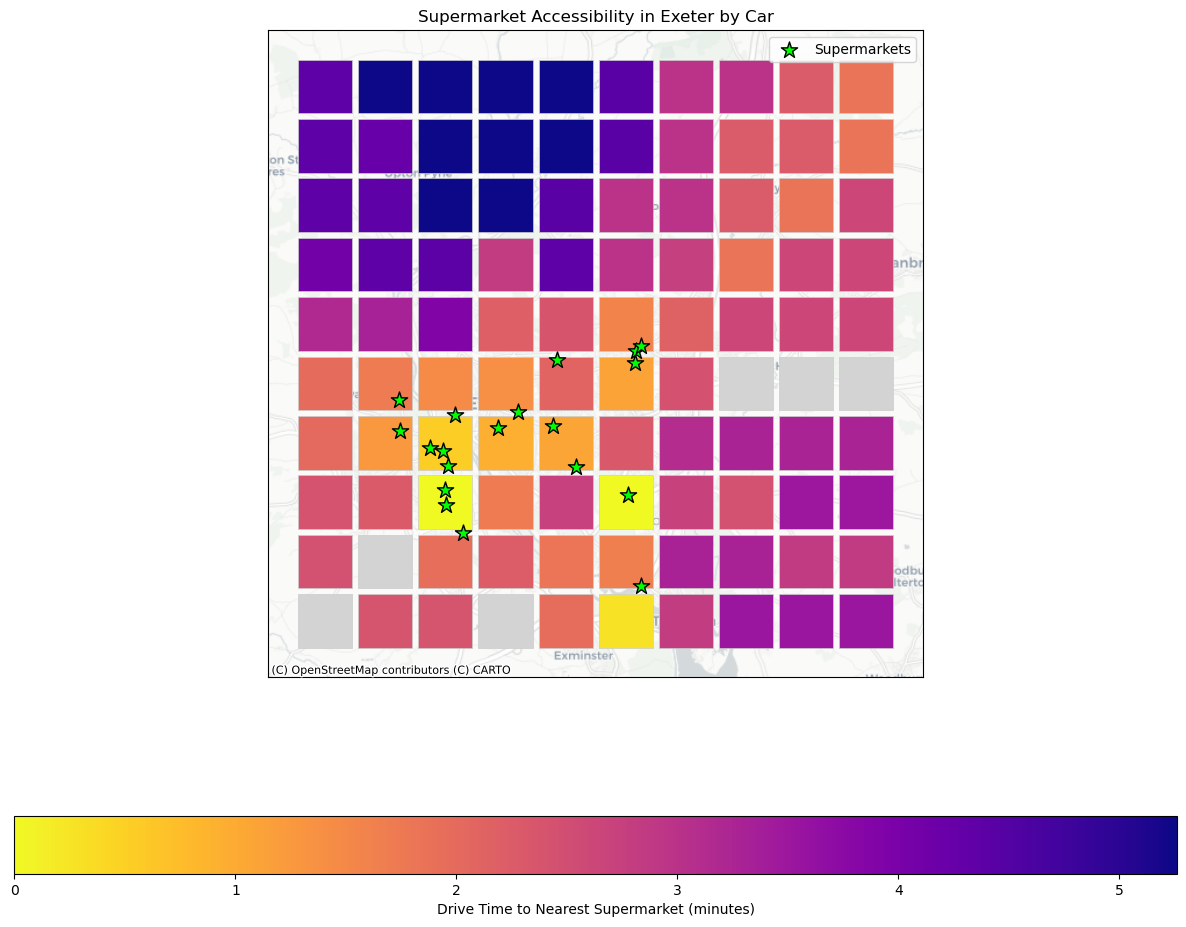

In [15]:
# Project to Web Mercator for plotting
lsoa_plot = lsoa_gdf.to_crs(epsg=3857)
supermarkets_plot = supermarkets.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot the choropleth map of accessibility
lsoa_plot.plot(column='accessibility_mins', cmap='plasma_r', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True,
               missing_kwds={'color': 'lightgrey', 'label': 'No Path'},
               legend_kwds={'label': "Drive Time to Nearest Supermarket (minutes)", 'orientation': "horizontal"})

# Plot supermarket locations
supermarkets_plot.plot(ax=ax, marker='*', color='lime', markersize=150, edgecolor='black', label='Supermarkets')

ax.set_title('Supermarket Accessibility in Exeter by Car')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=12)

plt.show()

# Discussion:
# - This map immediately highlights areas of good and poor accessibility. The dark purple areas have very short drive times to a supermarket, while the yellow areas are less well-served.
# - This type of analysis is invaluable for urban planning, real estate, and public service provision. It can identify service deserts and inform decisions about where to locate new services.